# 実験概要
## CMNによる特徴量抽出
**ケプストラム平均正規化** (Cepstrum Mean Normalization : CMN) を使用し、特徴量を抽出する。
切り出した波形に対して**離散フーリエ変換** (Discrete Fourier Transform : DFT) を行い、絶対値を取ることで**振幅スペクトル**を得る。
これに対して対数を取って**対数振幅スペクトル**に変換し、逆離散フーリエ変換 (Inverse Discrete Fourier Transform : IDFT) を行うことで、ケプストラム領域へと変換し、先頭50要素を切り出し、結合した100要素の配列を前処理として返す。
この前処理は
```
left, right, posture = pp.slicer("raw\\" + tester.**.**.value)
cepstrum = pp.cmn_denoise(left, right)
```
によって行われる。

## DNNによる寝姿勢分類
DNNによって前処理したデータから学習・分類を行う。

# モジュールのインポート

In [1]:
import numpy as np

# 自作モジュール
import datapath as dpath
import preprocess as pp

# DataLoaderの定義

In [2]:
import torch
from typing import Tuple
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# 学習用データセットを読み込むためのDataLoaderを定義
class train_datasets(Dataset):
    def __init__(self, identity, transforms=None, concat=True):
        self.transform = transforms
        self.concat = concat
        self.type, self.tester, self.mattress = dpath.getattributes(identity)
        print(self.type, self.tester, self.mattress)
        print("train, validation data")

        # テスト以外のrawを読み込む
        if concat:
            self.train_cepstrum = np.empty((0, 100))  # 100要素の配列
        else:
            self.train_cepstrum = []
        self.train_posture = np.empty(0)  # 姿勢データ配列

        
        # mattressに該当するrawのpathを読み込む
        # train_paths = eval(f"dpath.{self.type}.serch('{self.mattress}')")
        
        train_paths = []
        for mat in dpath.mattress_all():
            if mat == self.mattress:
                continue
            train_paths.extend(eval(f"dpath.{self.type}.serch('{mat}', skip=[dpath.{self.type}.{self.tester}])"))
        train_paths = dpath.extract_position(train_paths, position="center")
        
        for p in train_paths:
            if identity.value == p:
                continue
            left, right, posture = pp.slicer(p)
            cepstrum = pp.cmn_denoise(left, right, concat=concat)
            for cep in cepstrum:
                if concat:
                    self.train_cepstrum = np.vstack((self.train_cepstrum, cep)) if self.train_cepstrum.size else cep
                else:
                    self.train_cepstrum.append(cep)
            self.train_posture = np.append(self.train_posture, posture) if self.train_posture.size else posture

    def __len__(self):
        return len(self.train_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        if self.concat:
            cepstrum = torch.tensor(self.train_cepstrum[idx].reshape(1, -1), dtype=torch.float32)
        else:
            cepstrum = torch.tensor(self.train_cepstrum[idx], dtype=torch.float32)
        posture = torch.tensor(self.train_posture[idx]-1, dtype=torch.long)
        if self.transform:
            cepstrum = self.transform(cepstrum)
        return cepstrum, posture


# test用データセット
class test_datasets(Dataset):
    def __init__(self, identity, transform=None, concat=True):
        self.transform = transform
        self.concat = concat
        self.type, self.tester, self.mattress = dpath.getattributes(identity)
        print("test")

        # 前処理したrawを読み込む
        self.left, self.right, self.test_posture = pp.slicer(identity.value)
        self.test_cepstrum = pp.cmn_denoise(self.left, self.right, concat=concat)

    def __len__(self):
        return len(self.test_posture)

    def __getitem__(self, idx) -> Tuple[torch.tensor, torch.tensor]:
        if self.concat:
            cepstrum = torch.tensor(self.test_cepstrum[idx].reshape(1, -1), dtype=torch.float32)
        else:
            cepstrum = torch.tensor(self.test_cepstrum[idx], dtype=torch.float32)
        posture = torch.tensor(self.test_posture[idx]-1, dtype=torch.long)
        if self.transform:
            cepstrum = self.transform(cepstrum)
        return cepstrum, posture

# 学習＆検証

In [3]:
import torch
import random
import os

def seed_everything(seed=0):
    random.seed(seed)  # Python標準のrandomモジュールのシードを設定
    os.environ['PYTHONHASHSEED'] = str(seed)  # ハッシュ生成のためのシードを環境変数に設定
    np.random.seed(seed)  # NumPyの乱数生成器のシードを設定
    torch.manual_seed(seed)  # PyTorchの乱数生成器のシードをCPU用に設定
    torch.cuda.manual_seed(seed)  # PyTorchの乱数生成器のシードをGPU用に設定
    torch.backends.cudnn.deterministic = True  # PyTorchの畳み込み演算の再現性を確保

seed_everything()  # 上述のシード設定関数を呼び出し

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
# 被験者
identity = dpath.LMH.M004.value.ka_center

# データの形
concat = True

train_val = train_datasets(identity, concat=concat)
test = test_datasets(identity, concat=concat)
batch_size = 128

n_samples = len(train_val)
train_size = int(n_samples * 0.8)    # [train : val] を [8 : 2] に分割
val_size = n_samples - train_size

train, val = torch.utils.data.random_split(train_val, [train_size, val_size])

train_loader = DataLoader(
    train,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    val,
    batch_size=batch_size,
    shuffle=True
)

test_loader = DataLoader(
    test,
    shuffle=False,
)

LMH M004 ka
train, validation data
raw\LMH\M003\fld_center | data[171 / 312]
raw\LMH\M003\flf_center | data[37 / 178]
raw\LMH\H002\st_center | data[194 / 230]
raw\LMH\L001\st_center | data[186 / 208]
raw\LMH\L003\st_center | data[173 / 208]
raw\LMH\M002\fld_center | data[232 / 389]
raw\LMH\M002\st_center | data[174 / 438]
raw\LMH\M001\fld_center | data[226 / 444]
raw\LMH\M001\st_center | data[192 / 324]
raw\LMH\M002\flf_center | data[65 / 257]
raw\LMH\H003\fl_center | data[204 / 223]
raw\LMH\M003\fls_center | data[348 / 642]
raw\LMH\M001\flf_center | data[89 / 297]
raw\LMH\H002\fl_center | data[212 / 238]
raw\LMH\L003\fl_center | data[186 / 223]
raw\LMH\L001\fl_center | data[171 / 238]
raw\LMH\M002\fls_center | data[238 / 427]
raw\LMH\M001\fls_center | data[190 / 352]
raw\LMH\H003\st_center | data[340 / 403]
raw\LMH\M003\st_center | data[220 / 481]
test
raw\LMH\M004\ka_center | data[125 / 306]


## 学習

### ResNetによる学習

In [14]:
import torch.optim as optim
import torch.nn as nn
import model_resnet as resnet
import model_har as har
import model_dnn as dnn
from torcheval.metrics import MulticlassConfusionMatrix

# モデルのインスタンス化
num_channel = 1
if not concat:
    num_channel = 2
net = har.HAR_resnet18(num_classes=4, num_channel=num_channel).to(device)

# 誤差関数を交差エントロピーで計算
criterion = nn.CrossEntropyLoss()

# 最適化アルゴリズム
lr = 8e-4
optimizer = optim.Adamax(net.parameters(), lr=lr)

confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)

train_accuracy, val_accuracy, test_accuracy = [], [], []
train_error, val_error, test_error = [], [], []

# 学習
n_epoch = 200
for epoch in range(n_epoch):
    # 精度と損失の初期化
    train_acc, train_loss = 0, 0
    val_acc, val_loss = 0, 0
    n_train, n_val = 0, 0
    test_loss, test_acc = 0, 0
    n_test = 0

    # 学習
    for train_input, train_label in train_loader:
        n_train += len(train_label)

        # 入力と正解ラベルをGPU上に移動
        input = train_input.to(device)
        label = train_label.to(device)
        # print(f'input : {input.shape}, label : {label.shape}')

        optimizer.zero_grad()
        output = net(input)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        predicted = torch.max(output, 1)[1]

        train_loss += loss.item()
        train_acc += (predicted == label).sum().item()

    # 検証
    for val_input, val_label in val_loader:
        n_val += len(val_label)

        val_input = val_input.to(device)
        val_label = val_label.to(device)

        val_output = net(val_input)
        loss = criterion(val_output, val_label)

        val_predicted = torch.max(val_output, 1)[1]

        val_loss += loss.item()
        val_acc += (val_predicted == val_label).sum().item()
        if epoch+1 == n_epoch:
            confusion_mat.update(val_predicted, val_label)

    # テスト
    for test_input, test_label in test_loader:
        n_test += len(test_label)

        test_input = test_input.to(device)
        test_label = test_label.to(device)

        test_output = net(test_input)
        loss = criterion(test_output, test_label)

        test_predicted = torch.max(test_output, 1)[1]

        test_loss += loss.item()
        test_acc += (test_predicted == test_label).sum().item()
        
    # 精度を確率に変換
    test_acc /= n_test
    test_loss = test_loss / n_test

    print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}")

    # 精度を確率に変換
    train_acc /= n_train
    val_acc /= n_val
    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val

    train_accuracy.append(train_acc*100)
    val_accuracy.append(val_acc*100)
    test_accuracy.append(test_acc*100)
    train_error.append(train_loss)
    val_error.append(val_loss)
    test_error.append(test_loss)

    if epoch+1 == n_epoch:
        confusion_mat.compute()

    if not epoch%1:
        print(f"Epoch[{epoch+1}/{n_epoch}] | train_loss: {train_loss:.5f} | train_acc: {train_acc:.5f} | val_loss: {val_loss:.5f} | val_acc: {val_acc:.5f}")



loss : 1.39399, acc : 0.29600
Epoch[1/200] | train_loss: 1.54680 | train_acc: 0.26348 | val_loss: 1.63048 | val_acc: 0.26883
loss : 1.41491, acc : 0.27200
Epoch[2/200] | train_loss: 1.44864 | train_acc: 0.28817 | val_loss: 1.65973 | val_acc: 0.26494
loss : 1.40904, acc : 0.27200
Epoch[3/200] | train_loss: 1.44391 | train_acc: 0.29012 | val_loss: 1.58716 | val_acc: 0.28831
loss : 1.35301, acc : 0.28800
Epoch[4/200] | train_loss: 1.42515 | train_acc: 0.31741 | val_loss: 1.60462 | val_acc: 0.33117
loss : 1.38943, acc : 0.31200
Epoch[5/200] | train_loss: 1.39358 | train_acc: 0.35315 | val_loss: 1.61208 | val_acc: 0.38182
loss : 1.50063, acc : 0.38400
Epoch[6/200] | train_loss: 1.31474 | train_acc: 0.41910 | val_loss: 1.48499 | val_acc: 0.43506
loss : 1.38659, acc : 0.38400
Epoch[7/200] | train_loss: 1.26520 | train_acc: 0.46524 | val_loss: 1.36498 | val_acc: 0.47143
loss : 1.27769, acc : 0.47200
Epoch[8/200] | train_loss: 1.14115 | train_acc: 0.51105 | val_loss: 1.35270 | val_acc: 0.55844


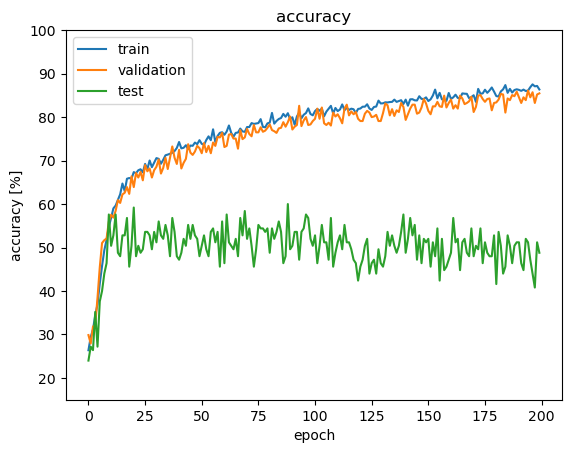

In [12]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_accuracy, label="train")
plt.plot(x, val_accuracy, label="validation")
plt.plot(x, test_accuracy, label="test")

# グラフのタイトルと軸ラベルの作成
plt.ylim(15, 100)
plt.title("accuracy")
plt.xlabel("epoch")
plt.ylabel("accuracy [%]")
plt.legend()
plt.savefig("../images/accuracy.jpg")

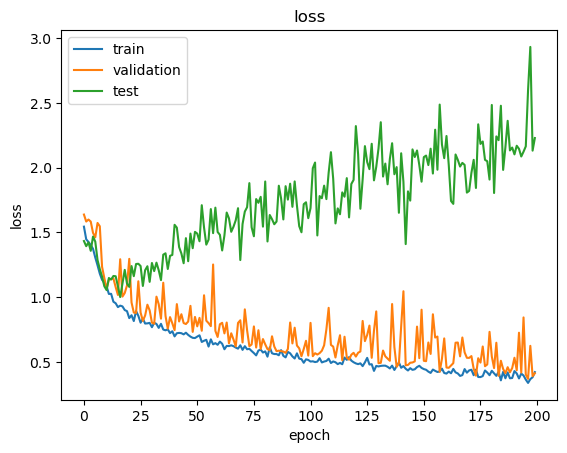

In [13]:
import matplotlib.pyplot as plt

x = np.arange(n_epoch)
plt.plot(x, train_error, label="train")
plt.plot(x, val_error, label="validation")
plt.plot(x, test_error, label="test")

# グラフのタイトルと軸ラベルの作成
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()
plt.savefig("../images/loss.jpg")

# 推定

In [8]:
from torcheval.metrics import MulticlassAccuracy
from torcheval.metrics import MulticlassRecall
from torcheval.metrics import MulticlassPrecision
from torcheval.metrics import MulticlassF1Score
from torcheval.metrics import MulticlassConfusionMatrix

accuracy = MulticlassAccuracy(
        average = "micro",
        num_classes = 4
)
recall = MulticlassRecall(
        average = "micro",
        num_classes = 4
)
precision = MulticlassPrecision(
        average = "micro",
        num_classes = 4
)
f1_score = MulticlassF1Score(
        average = "micro",
        num_classes = 4 
)
confusion_mat = MulticlassConfusionMatrix(
        num_classes = 4
)
loss = 0
n = 0

for input, label in test_loader:
        n += len(test_label)

        input = input.to(device)
        label = label.to(device)

        output = net(input)
        test_loss = criterion(output, label)

        predicted = torch.max(output, 1)[1]

        loss += test_loss.item()
        accuracy.update(predicted, label)
        recall.update(predicted, label)
        precision.update(predicted, label)
        f1_score.update(predicted, label)
        confusion_mat.update(predicted, label)
        
# 精度を確率に変換
acc = accuracy.compute().item()
recall = recall.compute().item()
precision = precision.compute().item()
f1_score = f1_score.compute().item()
confusion_mat = confusion_mat.compute()
test_loss = test_loss * batch_size / n_test

print(f"loss : {test_loss:.5f}, acc : {test_acc:.5f}, recall : {recall:.5f}, precision : {precision:.5f}, f1_score : {f1_score:.5f}")
print(confusion_mat)

loss : 2.80104, acc : 0.47200, recall : 0.48000, precision : 0.48000, f1_score : 0.48000
tensor([[ 6., 11., 14.,  5.],
        [ 0., 34.,  1.,  0.],
        [ 1., 10.,  9.,  8.],
        [ 2.,  5.,  8., 11.]])
